In [248]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [249]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [250]:
# Dataset investigation (train part)
print(train_df.shape)
display(train_df.head())
train_df.info()
print(train_df.dtypes)
missing_count = train_df.isna().sum()
missing_share = train_df.isna().mean()
display(pd.DataFrame({"missing_count": missing_count, "missing_share": missing_share}))
display(train_df.describe(include="all"))

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin         

,missing_count,missing_share
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [251]:
# Dataset preprocessing (train part)
# Missing values
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df['NumCabins'] = train_df['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
train_df.drop(['Cabin'], axis=1, inplace=True)
train_df.drop(['PassengerId'], axis=1, inplace=True)
train_df.drop(['Ticket'], axis=1, inplace=True)
# Categorical encoding
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
train_df = pd.get_dummies(train_df, columns=['Embarked'], prefix='Embarked')
# Additional features
train_df['Title'] = train_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
train_df.drop(['Name'], axis=1, inplace=True)

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(train_df[['Title']]) 
train_titles = enc.transform(train_df[['Title']])
cols = enc.get_feature_names_out(['Title'])
train_titles_df = pd.DataFrame(train_titles, columns=cols, index=train_df.index)
train_df = pd.concat([train_df, train_titles_df], axis=1)

train_df.drop(['Title'], axis=1, inplace=True)

age_features = (['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'NumCabins'] + [col for col in train_df if col.startswith('Title_')] + [col for col in train_df if col.startswith('Embarked_')])
known_age = train_df[train_df['Age'].notnull()]
unknown_age = train_df[train_df['Age'].isnull()]

X = known_age[age_features]
y = known_age['Age']

rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X, y)
X_unknown = unknown_age[age_features]
predicted_ages = rfr.predict(X_unknown)
train_df.loc[train_df['Age'].isnull(), 'Age'] = predicted_ages


In [252]:
# Dataset investigation after preprocessing (train part)
print(train_df.shape)
display(train_df.head())
train_df.info()
print(train_df.dtypes)
missing_count = train_df.isna().sum()
missing_share = train_df.isna().mean()
display(pd.DataFrame({"missing_count": missing_count, "missing_share": missing_share}))
display(train_df.describe(include="all"))

(891, 28)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,NumCabins,Embarked_C,Embarked_Q,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,0,3,0,22.0,1,0,7.2500,0,False,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,1,38.0,1,0,71.2833,1,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,3,1,26.0,0,0,7.9250,0,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,1,35.0,1,0,53.1000,1,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,3,0,35.0,0,0,8.0500,0,False,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Sex             891 non-null    int64  
 3   Age             891 non-null    float64
 4   SibSp           891 non-null    int64  
 5   Parch           891 non-null    int64  
 6   Fare            891 non-null    float64
 7   NumCabins       891 non-null    int64  
 8   Embarked_C      891 non-null    bool   
 9   Embarked_Q      891 non-null    bool   
 10  Embarked_S      891 non-null    bool   
 11  Title_Capt      891 non-null    float64
 12  Title_Col       891 non-null    float64
 13  Title_Countess  891 non-null    float64
 14  Title_Don       891 non-null    float64
 15  Title_Dr        891 non-null    float64
 16  Title_Jonkheer  891 non-null    float64
 17  Title_Lady      891 non-null    flo

,missing_count,missing_share
Survived,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
NumCabins,0,0.0
Embarked_C,0,0.0
Embarked_Q,0,0.0


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,NumCabins,Embarked_C,Embarked_Q,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891,891,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,723,814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.383838,2.308642,0.352413,29.691584,0.523008,0.381594,32.204208,0.267116,NaN,NaN,...,0.002245,0.044893,0.204265,0.002245,0.001122,0.580247,0.140292,0.001122,0.006734,0.001122
std,0.486592,0.836071,0.477990,13.839381,1.102743,0.806057,49.693429,0.547134,NaN,NaN,...,0.047351,0.207186,0.403390,0.047351,0.033501,0.493796,0.347485,0.033501,0.081830,0.033501
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.910400,0.000000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [253]:
# Dataset investigation (test part)
print(test_df.shape)
display(test_df.head())
test_df.info()
print(test_df.dtypes)
missing_count = test_df.isna().sum()
missing_share = test_df.isna().mean()
display(pd.DataFrame({"missing_count": missing_count, "missing_share": missing_share}))
display(test_df.describe(include="all"))

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,missing_count,missing_share
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,86,0.205742
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.002392
Cabin,327,0.782297


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [254]:
# Dataset preprocessing (test part)
# Missing values
test_df['NumCabins'] = test_df['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
test_df.drop(['Cabin'], axis=1, inplace=True)
test_df.drop(['PassengerId'], axis=1, inplace=True)
test_df.drop(['Ticket'], axis=1, inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
# Categorical encoding
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
test_df = pd.get_dummies(test_df, columns=['Embarked'], prefix='Embarked')
# Additional features
test_df['Title'] = test_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test_df.drop(['Name'], axis=1, inplace=True)

test_titles = enc.transform(test_df[['Title']])
test_titles_df = pd.DataFrame(test_titles, columns=cols, index=test_df.index)
test_df = pd.concat([test_df, test_titles_df], axis=1)

test_df.drop(['Title'], axis=1, inplace=True)

age_features = (['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'NumCabins'] + [col for col in test_df if col.startswith('Title_')] + [col for col in test_df if col.startswith('Embarked_')])
known_age = test_df[test_df['Age'].notnull()]
unknown_age = test_df[test_df['Age'].isnull()]

X = known_age[age_features]
y = known_age['Age']

rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X, y)
X_unknown = unknown_age[age_features]
predicted_ages = rfr.predict(X_unknown)
test_df.loc[test_df['Age'].isnull(), 'Age'] = predicted_ages

In [255]:
# Dataset investigation after preprocessing (test part)
print(test_df.shape)
display(test_df.head())
test_df.info()
print(test_df.dtypes)
missing_count = test_df.isna().sum()
missing_share = test_df.isna().mean()
display(pd.DataFrame({"missing_count": missing_count, "missing_share": missing_share}))
display(test_df.describe(include="all"))

(418, 27)


,Pclass,Sex,Age,SibSp,Parch,Fare,NumCabins,Embarked_C,Embarked_Q,Embarked_S,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,3,0,34.5,0,0,7.8292,0,False,True,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,1,47.0,1,0,7.0000,0,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,0,62.0,0,0,9.6875,0,False,True,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,0,27.0,0,0,8.6625,0,False,False,True,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,1,22.0,1,1,12.2875,0,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pclass          418 non-null    int64  
 1   Sex             418 non-null    int64  
 2   Age             418 non-null    float64
 3   SibSp           418 non-null    int64  
 4   Parch           418 non-null    int64  
 5   Fare            418 non-null    float64
 6   NumCabins       418 non-null    int64  
 7   Embarked_C      418 non-null    bool   
 8   Embarked_Q      418 non-null    bool   
 9   Embarked_S      418 non-null    bool   
 10  Title_Capt      418 non-null    float64
 11  Title_Col       418 non-null    float64
 12  Title_Countess  418 non-null    float64
 13  Title_Don       418 non-null    float64
 14  Title_Dr        418 non-null    float64
 15  Title_Jonkheer  418 non-null    float64
 16  Title_Lady      418 non-null    float64
 17  Title_Major     418 non-null    flo

,missing_count,missing_share
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
NumCabins,0,0.0
Embarked_C,0,0.0
Embarked_Q,0,0.0
Embarked_S,0,0.0


,Pclass,Sex,Age,SibSp,Parch,Fare,NumCabins,Embarked_C,Embarked_Q,Embarked_S,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418,418,418,...,418.0,418.000000,418.000000,418.0,418.0,418.000000,418.000000,418.000000,418.000000,418.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316,372,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.265550,0.363636,29.642193,0.447368,0.392344,35.576535,0.282297,NaN,NaN,NaN,...,0.0,0.050239,0.186603,0.0,0.0,0.574163,0.172249,0.002392,0.004785,0.0
std,0.841838,0.481622,13.310087,0.896760,0.981429,55.850103,0.628441,NaN,NaN,NaN,...,0.0,0.218700,0.390059,0.0,0.0,0.495062,0.378049,0.048912,0.069088,0.0
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,22.000000,0.000000,0.000000,7.895800,0.000000,NaN,NaN,NaN,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
50%,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,0.000000,NaN,NaN,NaN,...,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.0
75%,3.000000,1.000000,36.875000,1.000000,0.000000,31.471875,0.000000,NaN,NaN,NaN,...,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.0


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


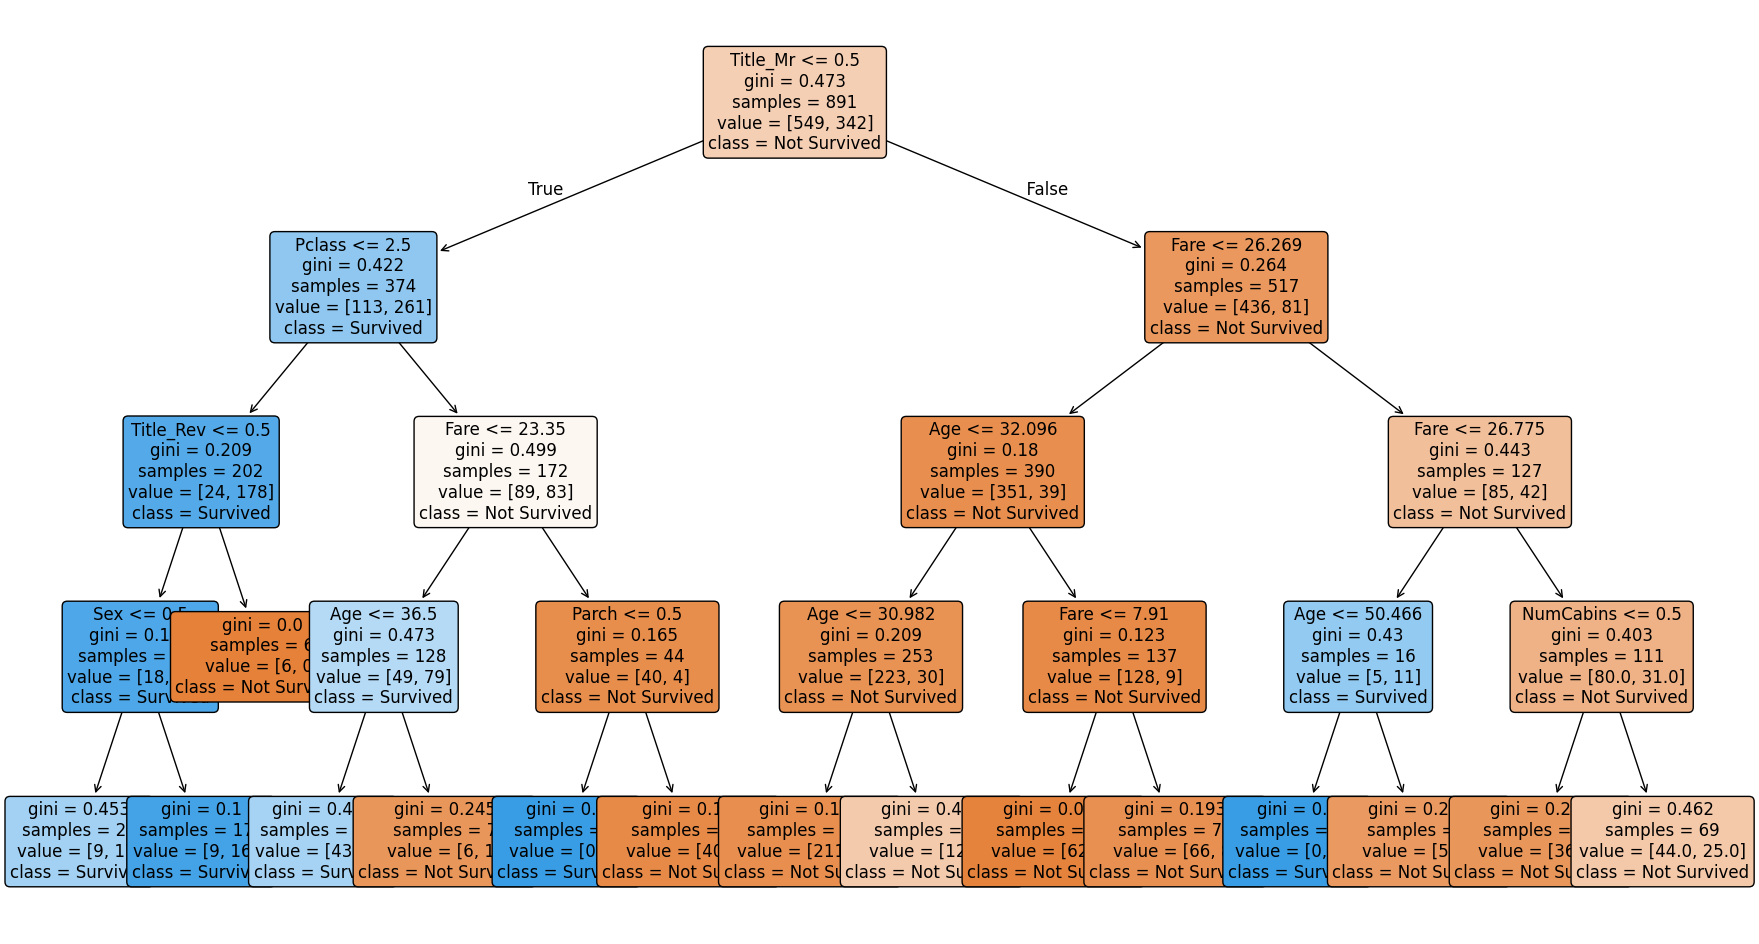

In [256]:
# Decision tree
features = [col for col in train_df.columns if col != 'Survived']
X_train = train_df[features]
y_train = train_df['Survived']

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

plt.figure(figsize=(22,12))
plot_tree(tree_clf, feature_names=features, class_names=['Not Survived', 'Survived'],
          filled=True, rounded=True, fontsize=12)
plt.show()

In [257]:
features = [col for col in train_df.columns if col != 'Survived']

X_test = test_df[features]

y_pred = tree_clf.predict(X_test)